# Hierarchical Clustering - UPGMA

---
## Learning Objectives

1. Implement a distance-based phylogeny neighbor joining algorithm
1. Understanding of hierarchical clustering
1. Manipulation of arrays and lists in Python


---
## Imports
You will need to install a package called `ete3` for this project. You can do this by the command `conda install ete3`.

In [1]:
from typing import List, Tuple, Dict
import numpy as np
import ete3

---
## Background

Today we will implement a distance-based phylogenetic tree construction method using the Neighbor-Joining (NJ) algorithm and Smith-Waterman local alignment scores. Unlike UPGMA (Unweighted Pair Group Method using Arithmetic averages), NJ produces unrooted trees and does not assume a constant evolutionary rate across lineages, making it more biologically realistic for analyzing sequence relationships.

We will use HIV-1 reverse transcriptase sequences to construct our phylogenetic tree. The Smith-Waterman algorithm will be used to generate pairwise local alignment scores, which will then be converted into distances for tree construction. This approach is particularly suitable for HIV sequence analysis as it:
1. Handles sequence variations effectively through local alignment
2. Accounts for potential rate heterogeneity across different viral strains
3. Does not assume a molecular clock

The ultimate output will be an unrooted phylogenetic tree representing the evolutionary relationships between the HIV-1 sequences, visualized using the ete3 library. This method provides insights into viral diversity and evolutionary patterns while avoiding the assumptions of simpler hierarchical clustering approaches.

The key innovations of this implementation are:
- Use of Smith-Waterman for sensitive local alignment scoring
- Implementation of Neighbor-Joining for unrooted tree construction
- More biologically realistic evolutionary model

## Neighbor-Joining Algorithm

**Input**: Distance matrix $D$ for $n$ sequences

**Initialization**:
- Let $n$ be the number of sequences
- Assign each sequence $i$ to its own leaf node
- Initialize tree $T$ with leaf nodes

**Iteration**:
While $n > 2$:
1. Calculate Q-matrix where:
   $Q(i,j) = (n-2)d(i,j) - \sum_{k=1}^n d(i,k) - \sum_{k=1}^n d(j,k)$

2. Find pair $(i,j)$ with minimum $Q(i,j)$

3. Calculate branch lengths:
   $d_i = \frac{d(i,j) + (r_i - r_j)/(n-2)}{2}$
   $d_j = d(i,j) - d_i$
   where $r_i = \sum_{k=1}^n d(i,k)$

4. Create new node $k$
   - Add branches from $k$ to $i$ and $j$ with lengths $d_i$ and $d_j$

5. Update distances to remaining nodes $x$:
   $d(k,x) = \frac{d(i,x) + d(j,x) - d(i,j)}{2}$

6. Remove nodes $i$ and $j$
7. Add node $k$ to active nodes
8. $n = n - 1$

**Termination**:
When $n = 2$ with remaining nodes $i$ and $j$:
- Add final branch between $i$ and $j$ with length $d(i,j)$
- Return unrooted tree $T$

---
## Distance metrics for comparing sequences

### Smith-Waterman
This was previously implemented. Feel free to import if you know how...or Copy & Paste.



In [24]:
def read_fasta(filename: str) -> Dict[str, str]:
    """Reads sequences from FASTA file.

    Args:
        filename (str): Path to FASTA file containing HIV RT sequences

    Returns:
        Dict[str, str]: Dictionary mapping sequence IDs to sequences

    Examples:
        >>> seqs = read_fasta("lafayette_SARS_RT.fasta")
        >>> len(seqs) > 0
        True
    """

    # initialize dictionary to store sequences
    sequences = {}

    # read sequences from file
    with open(filename, 'r') as file:
        sequence_id = None
        sequence_data = []
        for line in file:
            line = line.strip()

            # get sequence ID
            if line.startswith(">"):
                if sequence_id is not None:
                    sequences[sequence_id] = ''.join(sequence_data)

                # reset sequence ID and data
                sequence_id = line[1:]
                sequence_data = []
            else:
                # append sequence data
                sequence_data.append(line)

        # add last sequence
        if sequence_id is not None:
            sequences[sequence_id] = ''.join(sequence_data)
    return sequences
    

In [ ]:
def smith_waterman(
    sequence1: str,
    sequence2: str,
    match_score: float = 2.0,
    mismatch_penalty: float = -1.0,
    gap_penalty: float = -1.0
) -> float:
    """Implements Smith-Waterman local alignment algorithm.

    Args:
        sequence1 (str): First HIV RT sequence
        sequence2 (str): Second HIV RT sequence
        match_score (float): Score for matching characters
        mismatch_penalty (float): Penalty for mismatched characters
        gap_penalty (float): Penalty for gaps

    Returns:
        float: Normalized similarity score between sequences

    Examples:
        >>> seq1 = "ACGT"
        >>> seq2 = "ACGT"
        >>> smith_waterman(seq1, seq2)
        1.0
    """

    # initialize scoring matrix
    score_matrix = np.zeros((len(sequence1) + 1, len(sequence2) + 1)).astype(int)

    # fill in scoring matrix
    max_score = 0
    for i in range(1, len(sequence1) + 1):
        for j in range(1, len(sequence2) + 1):
            diag_score = score_matrix[i - 1][j - 1] + (match_score if sequence1[i - 1] == sequence2[j - 1] else mismatch_penalty)
            up_score = score_matrix[i - 1][j] + gap_penalty
            left_score = score_matrix[i][j - 1] + gap_penalty
            score_matrix[i][j] = max(0, diag_score, up_score, left_score)
            max_score = max(max_score, score_matrix[i][j])

    # normalize score
    return max_score / (min(len(sequence1), len(sequence2)) * match_score)

In [ ]:
def build_distance_matrix(sequences: Dict[str, str]) -> Tuple[np.ndarray, List[str]]:
    """Builds distance matrix using Smith-Waterman scores.

    Args:
        sequences (Dict[str, str]): Dictionary of HIV RT sequences

    Returns:
        Tuple[np.ndarray, List[str]]: Distance matrix and list of sequence IDs

    Examples:
        >>> seqs = read_fasta("lafayette_SARS_RT.fasta")
        >>> mat, ids = build_distance_matrix(seqs)
        >>> mat[0:3, 0:3]  # Show 3x3 slice of distance matrix
        array([[0.000, 0.004, 0.012],
              [0.004, 0.000, 0.012],
              [0.012, 0.012, 0.000]])
        >>> len(ids)  # Number of sequences
        19
    """
    
    # initialize distance matrix
    seq_ids = list(sequences.keys())
    distance_matrix = np.zeros((len(seq_ids), len(seq_ids)))

    # fill in distance matrix
    for i in range(len(seq_ids)):
        for j in range(i + 1, len(seq_ids)):
            score = smith_waterman(sequences[seq_ids[i]], sequences[seq_ids[j]])

            # convert similarity score to distance
            distance = 1 - score  
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    
    return distance_matrix, seq_ids

In [ ]:
def get_min_distance(matrix):
    ''' Function to find the smallest value off-daigonal in the distance
    matrix provided. This is used in the UPGMA algorithm.
    
    Args: 
        matrix (2D numpy array): a distance matrix

    Returns:
        min (float): The smallest distance in the matrix
        pos (tuple): The x and y position of the smallest distance
    
    '''

    # initialize minimum value and position
    min_val = np.inf
    pos = (-1, -1)
    
    # find minimum value and position
    for i in range(matrix.shape[0]):
        for j in range(i + 1, matrix.shape[1]):
            if matrix[i, j] < min_val:
                min_val = matrix[i, j]
                pos = (i, j)
    
    return min_val, pos

In [31]:
def neighbor_joining(
    distance_matrix: np.ndarray,
    labels: List[str]
) -> str:
    """Implements Neighbor-Joining algorithm for phylogenetic tree construction.

    Args:
        distance_matrix (np.ndarray): Distance matrix from Smith-Waterman scores
        labels (List[str]): Sequence identifiers

    Returns:
        str: Newick format tree string

    Examples:
        >>> seqs = read_fasta("lafayette_SARS_RT.fasta")
        >>> mat, ids = build_distance_matrix(seqs)
        >>> tree = neighbor_joining(mat, ids)
        >>> tree.startswith("((DM1:0.002,DM2:0.002)")  # Start of Newick string
        True
        >>> tree.count(",")  # Number of separators in tree
        18
    """

    class Node:
        def __init__(self, identifier):
            self.identifier = identifier
            self.children = []

        def is_leaf(self):
            return len(self.children) == 0

        def to_newick(self):
            if self.is_leaf():
                return self.identifier
            else:
                parts = []
                for child, dist in self.children:
                    parts.append(f"{child.to_newick()}:{dist:.4f}")
                return f"({','.join(parts)})"

    # create leaf nodes from labels
    tree = [Node(label) for label in labels]
    n = len(labels)

    # iterate until only two nodes remain
    while n > 2:
        # calculate Q-matrix
        row_sums = distance_matrix.sum(axis=1, keepdims=True)
        Q = (n - 2) * distance_matrix - (row_sums + row_sums.T)
        np.fill_diagonal(Q, np.inf)

        # find pair (i, j)
        i, j = np.unravel_index(np.argmin(Q), Q.shape)
        if i > j:
            i, j = j, i

        # calculate branch lengths
        r_i = distance_matrix[i].sum()
        r_j = distance_matrix[j].sum()
        d_ij = distance_matrix[i, j]
        d_i = 0.5 * (d_ij + (r_i - r_j) / (n - 2))
        d_j = d_ij - d_i

        # create new internal node
        k = Node(f"internal_{i}_{j}")
        k.children.append((tree[i], d_i))
        k.children.append((tree[j], d_j))

        # update distance matrix for new node
        new_row = 0.5 * (distance_matrix[i, :] + distance_matrix[j, :] - d_ij)
        distance_matrix = np.vstack([distance_matrix, new_row])
        new_col = np.append(new_row, 0.0).reshape(-1, 1)
        distance_matrix = np.hstack([distance_matrix, new_col])

        # remove old rows/cols
        distance_matrix = np.delete(distance_matrix, j, axis=0)
        distance_matrix = np.delete(distance_matrix, j, axis=1)
        distance_matrix = np.delete(distance_matrix, i, axis=0)
        distance_matrix = np.delete(distance_matrix, i, axis=1)

        # remove merged nodes, add new node
        tree.pop(j)
        tree.pop(i)
        tree.append(k)
        n -= 1

    # final connection
    node_a, node_b = tree[0], tree[1]
    d_final = distance_matrix[0, 1]
    root = Node("root")
    root.children.append((node_a, d_final / 2.0))
    root.children.append((node_b, d_final / 2.0))

    return f"{root.to_newick()};"

In [32]:
def plot_tree(newick_tree: str, out_file: str = "%%inline") -> None:
    """Plots phylogenetic tree using ete3.

    Args:
        newick_tree (str): Tree in Newick format
        out_file (str): Output file path or inline display
    """
    tree = ete3.Tree(newick_tree)
    ts = ete3.TreeStyle()
    ts.show_leaf_name = True
    ts.mode = "c"  # circular style
    return tree.render(out_file, tree_style=ts)

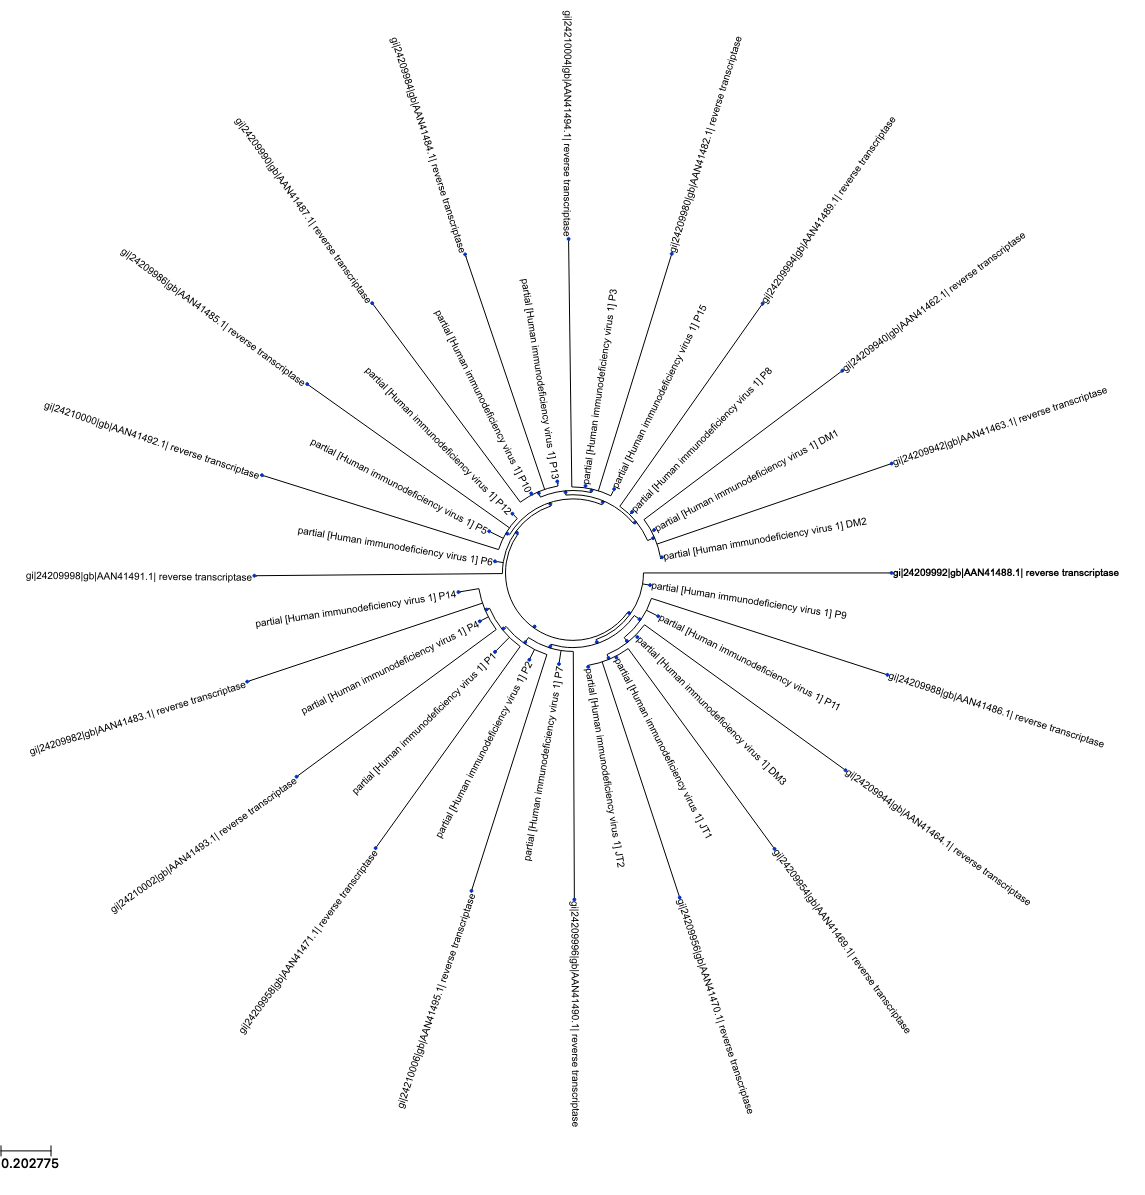

: 

In [ ]:
# Read HIV RT sequences
sequences = read_fasta("lafayette_SARS_RT.fasta")

# Build distance matrix using Smith-Waterman
dist_matrix, seq_ids = build_distance_matrix(sequences)

# Generate unrooted tree using Neighbor-Joining
tree = neighbor_joining(dist_matrix, seq_ids)

# Plot tree
plot_tree(tree)